In [3]:
# here, we will solve the burgers equation using an NN to reduce the error
# we will use an FDM solver for the burgers equation

# du/dt + u*du/dx = nu*d^2u/dx^2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [5]:
# here we use an FDM solver to solve the burgers equation

# first, we create the grid

# NOTE: these initializations and reference are given by the code in the PBDL book

N = 128
DX = 2/N
STEPS = 32 # this is how many steps we will take
DT = 1/STEPS
NU = 0.01/(N*np.pi)

initial_velocity = np.zeros(N) # this is in 1D (velocity for each point only)


# here is the final solution (reference)

reference = torch.tensor([0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312])

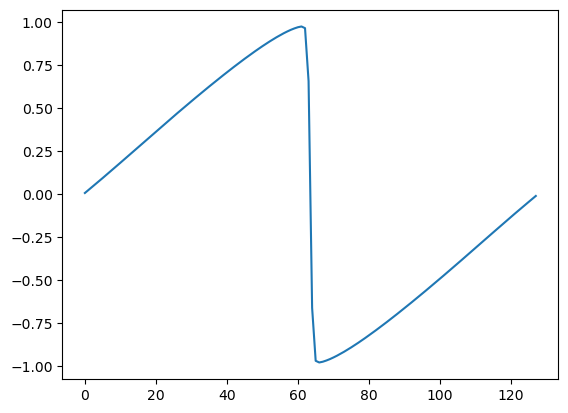

In [6]:
# here is the reference solution at time t=0.5 (step 16)
plt.plot(reference)
plt.show()

In [7]:
class NN_corrector(torch.nn.Module):
    def __init__(self, input_size=128, hidden_size=64, scale=0.1):
        super(NN_corrector, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size, bias=False)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size, bias=False)
        self.fc3 = torch.nn.Linear(hidden_size, input_size, bias=False)


        # Initialize weights
        torch.nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        torch.nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        torch.nn.init.normal_(self.fc3.weight, mean=0, std=0.01)

        # scaler
        self.scale = scale

    def forward(self, x):
        

        x = torch.nn.functional.leaky_relu(self.fc1(x))
        x = torch.nn.functional.leaky_relu(self.fc2(x))
        x = self.fc3(x)

        x = x * self.scale

        return x

In [43]:
def velocity_step(last_velocity, nu, dt, dx):
    # here we use the finite difference method to calculate the next velocity

    new_velocity = torch.zeros_like(last_velocity)

    for i in range(N):
        ui = last_velocity[i]
        ui1 = last_velocity[(i+1)] if i < N-1 else last_velocity[0]
        uineg1 = last_velocity[(i-1)] if i > 0 else last_velocity[N-1]
        new_velocity[i] = ui - dt * (ui * (ui1 - uineg1) / (2 * dx)) + nu * dt * (ui1 - 2*ui + uineg1) / (dx**2)

    return new_velocity



def loss_function(velocity, reference, corrector, lambda_reg=0.01):
    velocities = [velocity] # velocity is the initial velocity (at time t=0)

    # here we step through each step to get updated velocities
    for n in range(STEPS):
        # use a function here that uses the finite difference method to calculate the next step

        next_v = velocity_step(velocities[-1], NU, DT, DX)

        # correction AFTER (option 2)

        if not corrector:
            pass
        else:
            correction = corrector(next_v.float())
            next_v += correction

        # next_v += correction
        

        velocities.append(next_v)

    # calculate the l2 loss here

    loss = torch.norm(velocities[16] - reference, p=2)

    if not corrector:
        l2_reg = 0
    else:
        # adding loss to reduce NN effects
        l2_reg = torch.tensor(0.).float()
        for param in corrector.parameters():
            l2_reg += torch.norm(param, p=2)
        
    total_loss = loss +  l2_reg * lambda_reg

    return total_loss, velocities, loss

In [9]:
velocity = torch.tensor(np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ), requires_grad=True)
loss, velocities = loss_function(velocity, reference)
loss.backward()

TypeError: loss_function() missing 1 required positional argument: 'corrector'

In [180]:
print(loss)

tensor(1.3737, grad_fn=<LinalgVectorNormBackward0>)


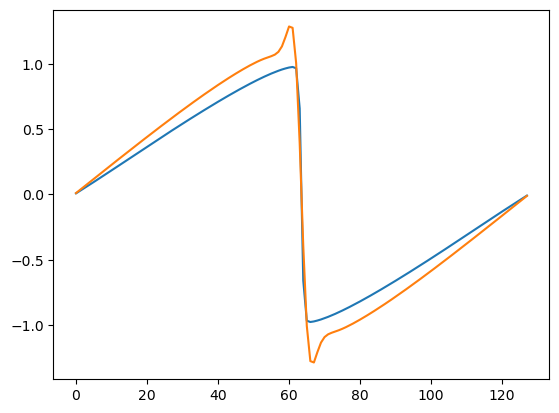

In [186]:
plt.plot(reference)
plt.plot(velocities[12].detach().numpy())
plt.show()

In [ ]:
velocity.zero_grad()

In [11]:
velocities_copy = 0

In [41]:
def train(use_NN=True, learning_rate=3e-3, lambda_reg=0.1):

    velocity = torch.tensor(initial_velocity, requires_grad=True)
    LR = 3e-3



    # OPTIMIZATION TIME
    
    if use_NN:
        corrector = NN_corrector(input_size=128, hidden_size=64, scale=1).float()
        optimizer = torch.optim.Adam([velocity, *corrector.parameters()], lr=LR)


    else:
        corrector = None
        optimizer = torch.optim.Adam([velocity], lr=LR)

    # 0.01 works well without NN

    grads = []

    # let's use the adam optimizer instead

    for optim_step in range(10000):


        # print(velocity[0])

        loss, velocities, last_state_loss = loss_function(velocity, reference, corrector, lambda_reg=lambda_reg)

        velocities_copy = velocities
        # print("MADE IT OUT")

        velocity_test = velocities[0].cpu().detach().numpy()
        reference_new = np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] )
        l2_error = np.linalg.norm(velocity_test - reference_new)



        print(last_state_loss.item(), l2_error, loss.item())

        if loss < 2.8:
            return velocities


        # loss.backward
        loss.backward()

        # print(corrector.fc1.weight.grad)

        grads.append(velocity.grad)

        optimizer.step()
        # with torch.no_grad():
        #     velocity -= LR * velocity.grad

        optimizer.zero_grad()
        # velocity.grad.zero_()

# ONLY WITH PDE SOLVER

In [31]:
velocities = train(use_NN = False, learning_rate=0.01)

7.000939423485818 8.0 7.000939423485818
6.971202908033035 7.969452867779655 6.971202908033035
6.941391347733061 7.938932909428424 6.941391347733061
6.91148835013222 7.908439994259026 6.91148835013222
6.88147163064221 7.877973912779513 6.88147163064221
6.851310493652985 7.847534400548487 6.851310493652985
6.82096226611843 7.817121144109439 6.82096226611843
6.790367172159262 7.7867337723339904 6.790367172159262
6.7594408853054615 7.756371836558231 6.7594408853054615
6.728063651273969 7.726034782167374 6.728063651273969
6.69606454977958 7.6957219142397255 6.69606454977958
6.663199825096428 7.665432360386261 6.663199825096428
6.629128148309392 7.635165033416053 6.629128148309392
6.593404955567836 7.604918592905831 6.593404955567836
6.55560376463797 7.574691405793976 6.55560376463797
6.516089202495671 7.54448157730531 6.516089202495671
6.4805289197240326 7.514287635674024 6.4805289197240326
6.4765702440478865 7.484114187874827 6.4765702440478865
6.436319510548458 7.454010320596327 6.4363195

In [141]:
def plotter(velocities):
    plt.figure(figsize=(20,3))
    counter = 0
    for i in [0, 3, 5, 7, 10, 13, 16]:
        print(counter)
        plt.subplot(1, 7, counter+1)
        plt.plot(velocities[i].detach().numpy())
        if i == 0:
            plt.plot(np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ))

        if i == 16:
            plt.plot(reference)
        plt.title(f"Timestep {i}")
        plt.ylim(-1, 1)
        # plt.plot(reference)
        counter += 1
    plt.show()

    # plt.plot(velocities[0].detach().numpy())
    # plt.title("Timestep 0")
    # plt.plot(np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ))
    # plt.ylim(-1, 1)
    # plt.show()

    # plt.plot(velocities[0].detach().numpy())
    # plt.title("Timestep 16")
    # plt.plot(np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ))
    # plt.ylim(-1, 1)
    # plt.show()

0
1
2
3
4
5
6


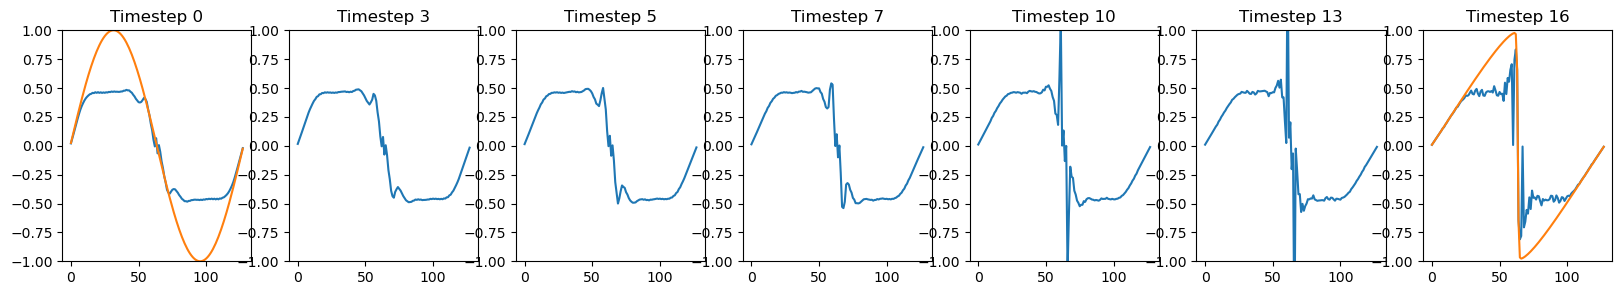

In [142]:
plotter(velocities)

## NN with uncontrolled losses

In [48]:
velocities_NN = train(use_NN = True, learning_rate=3e-3, lambda_reg=0)

hello
7.000939423485818 8.0 7.000939423485818
6.971220366900894 7.969452867779662 6.971220366900894
6.9402639717837165 7.938935165662459 6.9402639717837165
6.901715672715625 7.908426894028819 6.901715672715625
6.839947432941686 7.877875521578842 6.839947432941686
6.706891779128697 7.847315515750027 6.706891779128697
6.343599879702133 7.817114691452317 6.343599879702133
5.902419856451163 7.788525104141493 5.902419856451163
5.971390838821137 7.7994672356003 5.971390838821137
6.219843357881162 7.806637892084051 6.219843357881162
6.313347578913615 7.811108889075076 6.313347578913615
6.335011980819826 7.81342128825042 6.335011980819826
6.300203814787054 7.813863947439332 6.300203814787054
6.19194929288232 7.8125547427132505 6.19194929288232
5.948623358346925 7.809433984693611 5.948623358346925
5.363955693181332 7.804173511385277 5.363955693181332
3.619528431788319 7.795895333746117 3.619528431788319
7.595526209112824 7.782769890705464 7.595526209112824
1.8925528795771036 7.787401489444823 1

0
1
2
3
4
5
6


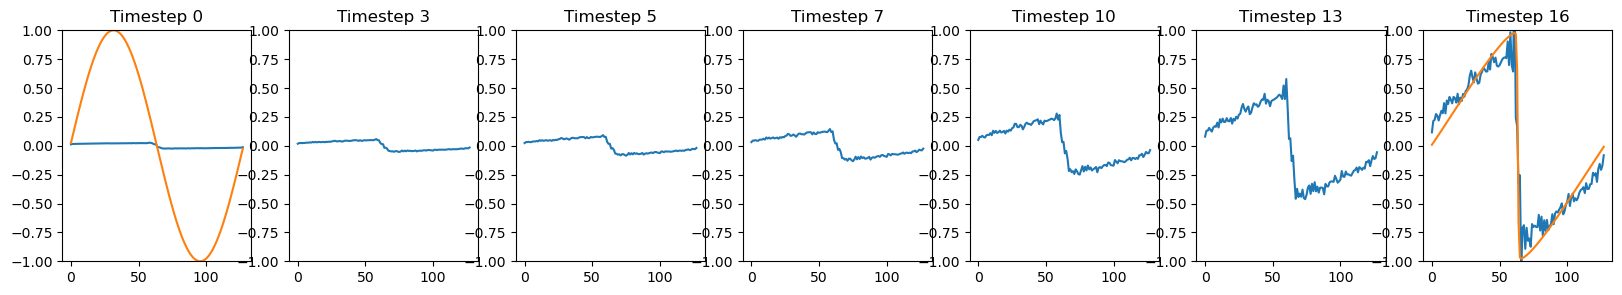

In [143]:
plotter(velocities_NN)

## WITH NN CORRECTOR

In [52]:
velocities_NN_uncontrolled = train(use_NN = True, learning_rate=3e-3, lambda_reg=0.05)

hello
7.000939423485818 8.0 7.12422934387547
6.971201865515414 7.969452867779657 7.067679850897494
6.941375279904706 7.938933123626646 7.014891015471322
6.9114641874049 7.908440104387738 6.967299263081341
6.8814478013257245 7.877973675229567 6.924506550614045
6.851296595708633 7.847533704685205 6.885826020912433
6.820955954870154 7.817120158107521 6.8510786317344206
6.790363432292636 7.786732707661782 6.818386839155848
6.7594376005603864 7.756370873211301 6.786290092803438
6.728060853055271 7.726034068371684 6.754327351546439
6.6960630287865275 7.695721571646285 6.721649468083131
6.663198486595609 7.665432498628947 6.6877226481877345
6.62912642880147 7.6351657329733955 6.652318383742028
6.593404321929452 7.604919911434562 6.615040752103564
6.555604023655508 7.574693394863227 6.5755634194068655
6.5160891855108884 7.5444842836801245 6.5343547364670185
6.480531170745228 7.514291097313768 6.497171150301431
6.476575963148243 7.484118440172859 6.491774955713518
6.436317186236856 7.4540154059

0
1
2
3
4
5
6


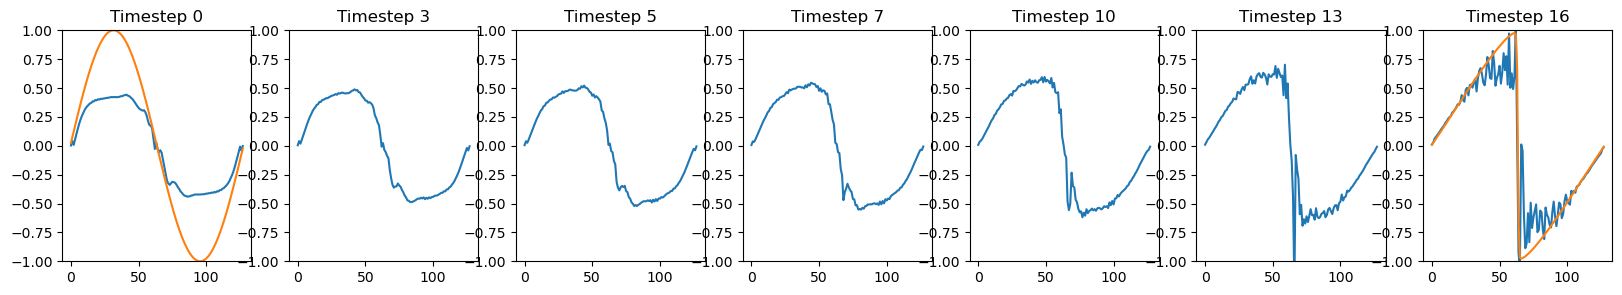

In [144]:
plotter(velocities_NN_uncontrolled)

In [ ]:
loss

7.000939392541187

In [142]:
# now -> add NN loss term that makes sure it follows the burger equation w.r.t the beginning of the PDE solver

## USING THE  